# Uploading dataset and setting up directory

# Imports

In [69]:
# Miscellaneous
import io
import os
from warnings import filterwarnings

In [70]:
# display
from tqdm import tqdm

In [71]:
# math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
# image related
import cv2
from PIL import Image

In [73]:
# tensorflow and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, ReLU, GlobalAveragePooling2D

In [74]:
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Data Preparation

In [75]:
train_path = "data/Training"
test_path = "data/Testing"

In [76]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [77]:
X_train, y_train = [], []
X_test, y_test = [], []

image_size = 150
for label in labels:
    folderPath = os.path.join(train_path, label)
    for fn in tqdm(os.listdir(folderPath)):
        fnPath = os.path.join(folderPath, fn)
        img = cv2.imread(fnPath)
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(label)

for label in labels:
    folderPath = os.path.join(test_path, label)
    for fn in tqdm(os.listdir(folderPath)):
        fnPath = os.path.join(folderPath, fn)
        img = cv2.imread(fnPath)
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(label)

# converting these lists to np arrays for more efficiency
# Combine then split with stratify
X_train.extend(X_test)
y_train.extend(y_test)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1,random_state=42, stratify=y_train)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

100%|█████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 150.14it/s]


In [78]:
# validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42, stratify=y_train)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2643, 150, 150, 3), (2643, 4), (294, 150, 150, 3), (294, 4))

In [79]:
# generating data
batch_size = 32
def create_datagen(X_train, y_train, X_val, y_val):
    train_datagen = ImageDataGenerator (
        rotation_range = 30,
        rescale = 1./255,

        shear_range = 0.1,
        zoom_range = 0.2,

        horizontal_flip = True,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow(
        X_train, y_train,
        batch_size=batch_size
    )

    val_gen = val_datagen.flow(
        X_val, y_val,
        batch_size=batch_size
    )

    return train_gen, val_gen

# Transfered Learning Model
Here we're going to be setting up the model using ImageNet and then compile it

In [80]:
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

tl_model = effnet.output
tl_model = tf.keras.layers.GlobalAveragePooling2D()(tl_model)
tl_model = tf.keras.layers.Dropout(rate=0.5)(tl_model)
tl_model = tf.keras.layers.Dense(4, activation='softmax')(tl_model)
tl_model = tf.keras.models.Model(inputs=effnet.input, outputs = tl_model)

tl_model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics= ['accuracy'])
tl_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 150, 150, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 150, 150, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                            

## Model CallBacks

In [81]:
tensorboard = TensorBoard(log_dir = 'logs')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

checkpoint_tl = ModelCheckpoint("my_effnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

## Training the model

In [82]:
epochs = 25

train_gen, val_gen = create_datagen(X_train, y_train, X_val, y_val)
tl_history = tl_model.fit (
    train_gen,
    epochs = epochs,
    validation_data = val_gen,
    validation_steps = len(y_val)//batch_size,
    steps_per_epoch = len(y_train)//batch_size,
    callbacks = [tensorboard,checkpoint_tl,reduce_lr],
    verbose = 1,
)

Epoch 1/25
82/82 [==============================] - ETA: 0s - loss: 0.6224 - accuracy: 0.7675
Epoch 1: val_accuracy improved from -inf to 0.14931, saving model to my_effnet.h5
82/82 [==============================] - 25s 210ms/step - loss: 0.6224 - accuracy: 0.7675 - val_loss: 1.7852 - val_accuracy: 0.1493 - lr: 0.0010
Epoch 2/25
82/82 [==============================] - ETA: 0s - loss: 0.3712 - accuracy: 0.8671
Epoch 2: val_accuracy improved from 0.14931 to 0.15625, saving model to my_effnet.h5
82/82 [==============================] - 15s 188ms/step - loss: 0.3712 - accuracy: 0.8671 - val_loss: 2.1444 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 3/25
82/82 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.8977
Epoch 3: val_accuracy did not improve from 0.15625
82/82 [==============================] - 15s 184ms/step - loss: 0.2944 - accuracy: 0.8977 - val_loss: 2.6229 - val_accuracy: 0.1528 - lr: 0.0010
Epoch 4/25
82/82 [==============================] - ETA: 0s - los

## Graphs

In [83]:
# setting up the colours
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

def plot_training_metrics(history):
  filterwarnings('ignore')

  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  range_epochs = [i for i in range(epochs)]
  fig, ax = plt.subplots(1, 2, figsize=(14,7))
  fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
              fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

  sns.despine()
  ax[0].plot(range_epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
            label = 'Training Accuracy')
  ax[0].plot(range_epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
            label = 'Validation Accuracy')
  ax[0].legend(frameon=False)
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')

  sns.despine()
  ax[1].plot(range_epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
            label ='Training Loss')
  ax[1].plot(range_epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
            label = 'Validation Loss')
  ax[1].legend(frameon=False)
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Training & Validation Loss')

  fig.show()

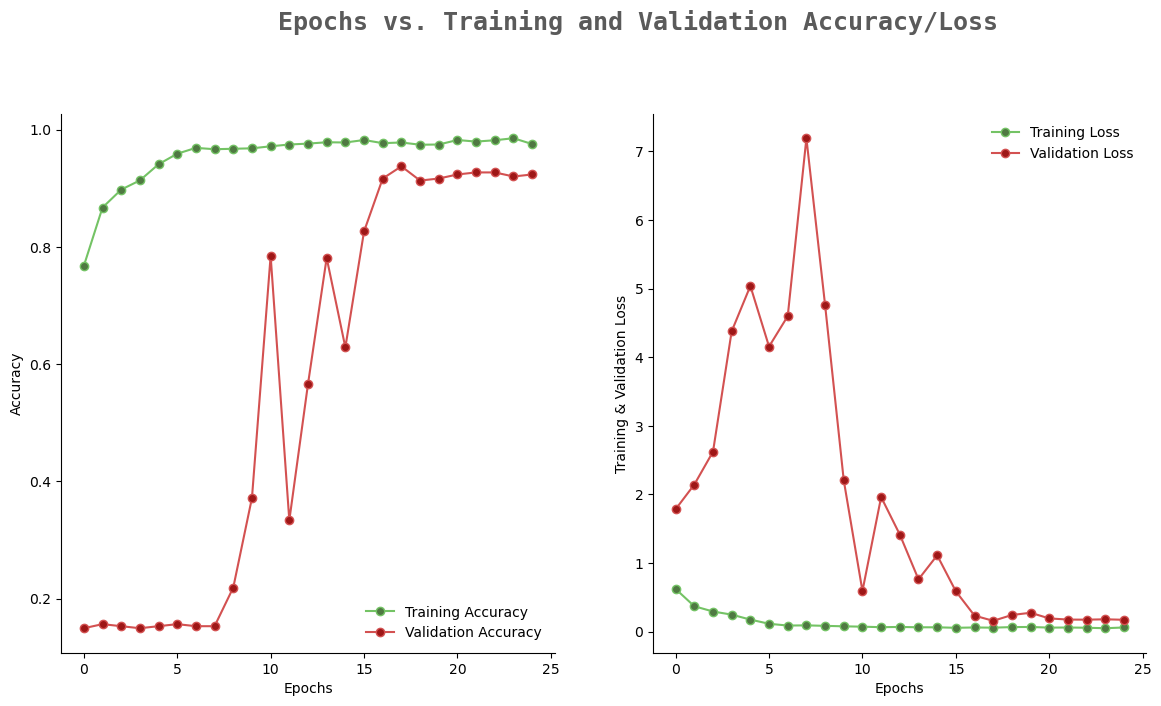

In [84]:
plot_training_metrics(tl_history)

## Prediction and Evaluation


In [85]:
def make_predictions(model, X_test, y_test):
    pred = model.predict(X_test / 255)
    pred = np.argmax(pred, axis=1)
    y_test_new = np.argmax(y_test,axis=1)
    return y_test_new, pred

In [86]:
def plot_confusion_matrix(y_test_new, pred):
    print(classification_report(y_test_new, pred), end="\n\n")

    fig,ax=plt.subplots(1,1,figsize=(14,7))
    sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
               cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
    fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
                 fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

    plt.show()

11/11 [==============================] - 3s 49ms/step
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        93
           1       0.97      0.83      0.90        94
           2       0.98      0.96      0.97        50
           3       0.90      1.00      0.95        90

    accuracy                           0.94       327
   macro avg       0.94      0.94      0.94       327
weighted avg       0.94      0.94      0.93       327




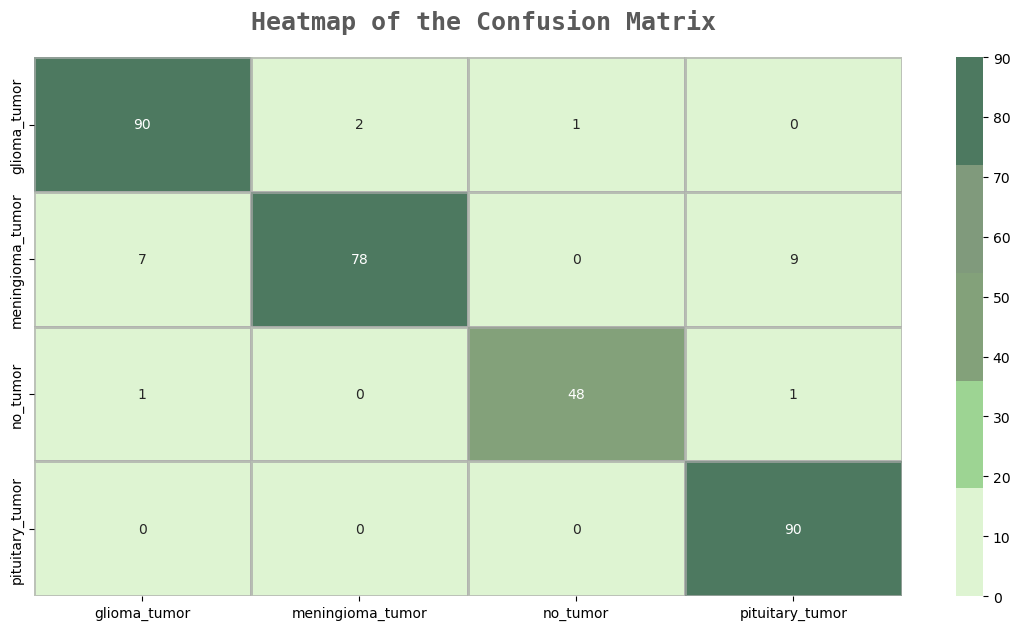

In [87]:
y_test_new, pred = make_predictions(tl_model, X_test, y_test)
plot_confusion_matrix(y_test_new, pred)

## Testing

In [113]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
def img_pred(model, image_filepath):
    img = Image.open(image_filepath)
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img / 255)
    p = np.argmax(p,axis=1)[0]
    return p

In [114]:
demo_dataset =[
    ("glioma_tumor", "data/Testing/glioma_tumor/image(1).jpg"),
    ("meningioma_tumor", "data/Testing/meningioma_tumor/image(1).jpg"),
    ("no_tumor", "data/Testing/no_tumor/image(1).jpg"),
    ("pituitary_tumor", "data/Testing/pituitary_tumor/image(1).jpg"),
    ("meningioma_tumor", "data/Testing/meningioma_tumor/image(2).jpg")
]

In [115]:
total_true = 0
print("Actual vs Predicted")
for n, (true_label, img_fp) in enumerate(demo_dataset):
    pred_i = img_pred(tl_model, img_fp)
    print(f"{n+1}. {true_label} vs {labels[pred_i]}")
    total_true += true_label == labels[pred_i]

print(f"Accuracy: {total_true * 100 / len(demo_dataset):.2f}%")

Actual vs Predicted
1/1 [==============================] - 0s 48ms/step
1. glioma_tumor vs glioma_tumor
1/1 [==============================] - 0s 38ms/step
2. meningioma_tumor vs meningioma_tumor
1/1 [==============================] - 0s 39ms/step
3. no_tumor vs no_tumor
1/1 [==============================] - 0s 56ms/step
4. pituitary_tumor vs pituitary_tumor
1/1 [==============================] - 0s 35ms/step
5. meningioma_tumor vs meningioma_tumor
Accuracy: 100.00%


In [116]:
labels[img_pred(tl_model, "data/Testing/pituitary_tumor/image(98).jpg")]

1/1 [==============================] - 0s 39ms/step


'pituitary_tumor'

# Loading in the model

In [91]:
# from tensorflow.keras.models import load_model

In [117]:
# tl_model = load_model('my_effnet.keras')

In [109]:
tf.keras.models.save_model(tl_model, "my_effnet.keras")